In [1]:
%matplotlib inline

In [2]:
from pycaret.regression import RegressionExperiment
import pickle

In [4]:
# Load data
current_time = "2024-11-14T12:57:37.266Z"

with open(f"./data/{current_time}/data_exact_df.pkl", "rb") as f:
    data_exact_df = pickle.load(f)
with open(f"./data/{current_time}/data_sim_df.pkl", "rb") as f:
    data_sim_df = pickle.load(f)
with open(f"./data/{current_time}/data_sim_noisy_df.pkl", "rb") as f:
    data_sim_noisy_df = pickle.load(f)
with open(f"./data/{current_time}/data_nmit_df.pkl", "rb") as f:
    data_nmit_df = pickle.load(f)
with open(f"./data/{current_time}/data_mit_df.pkl", "rb") as f:
    data_mit_df = pickle.load(f)

with open(f"./data/{current_time}/params.pkl", "rb") as f:
    params = pickle.load(f)

for key, value in params.items():
    print(f"{key}: {value}")

n_samples: 100
n_qubits: 8
backend_qpu_name: ibm_marrakesh
beta: 1
C: 80
n_features: 5
times: [0.0, 0.039269908169872414, 0.07853981633974483, 0.11780972450961724, 0.15707963267948966]
Js: [array([ 0.5479121 , -0.12224312,  0.71719584,  0.39473606, -0.8116453 ,
         0.9512447 ,  0.5222794 ])
 array([ 0.57212861, -0.74377273, -0.09922812, -0.25840395,  0.85352998,
         0.28773024,  0.64552323])
 array([-0.1131716 , -0.54552256,  0.10916957, -0.87236549,  0.65526234,
         0.2633288 ,  0.51617548])
 array([-0.29094806,  0.94139605,  0.78624224,  0.55676699, -0.61072258,
        -0.06655799, -0.91239247])
 array([-0.69142102,  0.36609791,  0.48952431,  0.93501946, -0.34834928,
        -0.25908059, -0.06088838])
 array([-0.62105728, -0.74015699, -0.04859015, -0.5461813 ,  0.33962799,
        -0.12569616,  0.66535639])
 array([ 0.4005302 , -0.37526672,  0.6645196 ,  0.60952871, -0.22504324,
        -0.42334379,  0.36499101])
 array([-0.72049503, -0.6001836 , -0.98527546,  0.57384

## Analyze features

In [5]:
features_exact_df = data_exact_df.drop(columns=["expected_value"])
features_sim_df = data_sim_df.drop(columns=["expected_value"])
features_sim_noisy_df = data_sim_noisy_df.drop(columns=["expected_value"])
features_nmit_df = data_nmit_df.drop(columns=["expected_value"])
features_mit_df = data_mit_df.drop(columns=["expected_value"])

print("Exact")
display(features_exact_df)

print("Simulator (noise free)")
display(features_sim_df)

print("Simulator (noisy)")
display(data_sim_noisy_df)

print("no mitigation")
display(features_nmit_df)

print("mitigation")
display(features_mit_df)

Exact


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,1.0,0.997143,-0.011673,0.988601,-0.023410,0.974452,-0.035272,0.954831,-0.047316
1,1.0,0.999386,-0.026768,0.997551,-0.053443,0.994509,-0.079931,0.990288,-0.106144
2,1.0,0.999583,0.020173,0.998331,0.040326,0.996248,0.060441,0.993338,0.080497
3,1.0,0.999764,-0.021083,0.999057,-0.042158,0.997879,-0.063219,0.996233,-0.084256
4,1.0,0.999099,-0.037258,0.996397,-0.074446,0.991900,-0.111493,0.985620,-0.148330
...,...,...,...,...,...,...,...,...,...
95,1.0,0.994186,-0.091382,0.976829,-0.181519,0.948188,-0.269179,0.908688,-0.353167
96,1.0,0.998317,-0.057992,0.993273,-0.115789,0.984886,-0.173196,0.973184,-0.230020
97,1.0,0.991026,0.131993,0.964271,0.261550,0.920234,0.386283,0.859738,0.503891
98,1.0,0.997931,0.015992,0.991787,0.031364,0.981749,0.045518,0.968114,0.057903


Simulator (noise free)


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,1.0,0.996226,-0.075480,0.990333,-0.119268,0.977967,-0.190539,0.962146,-0.250819
1,1.0,0.998336,-0.038585,0.996439,-0.045741,0.993053,-0.081062,0.988610,-0.106234
2,1.0,0.999029,0.010237,0.996147,0.051727,0.994240,0.064898,0.990414,0.087841
3,1.0,0.999068,-0.005100,0.997265,0.021124,0.996174,0.019058,0.993938,0.026898
4,1.0,0.999062,-0.006164,0.997308,0.019000,0.996230,0.015875,0.994043,0.022664
...,...,...,...,...,...,...,...,...,...
95,1.0,0.998798,-0.023766,0.997358,-0.016152,0.995677,-0.036787,0.993171,-0.047399
96,1.0,0.997988,-0.046728,0.995560,-0.061993,0.990772,-0.105339,0.984618,-0.138432
97,1.0,0.991653,0.121605,0.959893,0.271274,0.917511,0.388457,0.855088,0.507406
98,1.0,0.998451,-0.035471,0.996705,-0.039525,0.993768,-0.071767,0.989859,-0.093893


Simulator (noisy)


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0.865234,0.897308,-0.017904,0.874341,-0.107951,0.855934,-0.193551,0.860997,-0.191579,4.172305
1,0.865234,0.897357,0.015294,0.879928,-0.043029,0.872104,-0.097569,0.879833,-0.062553,0.567842
2,0.865234,0.895538,0.059117,0.879927,0.043055,0.877001,0.030896,0.875223,0.109558,1.871539
3,0.865234,0.896340,0.045364,0.880834,0.016024,0.877494,-0.009511,0.880297,0.055643,0.639599
4,0.865234,0.896388,0.044409,0.880866,0.014148,0.877459,-0.012314,0.880526,0.051893,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,0.865234,0.897031,0.028608,0.880817,-0.016898,0.875582,-0.058661,0.881994,-0.010248,1.664801
96,0.865234,0.897452,0.007972,0.879109,-0.057379,0.869455,-0.118882,0.877324,-0.091225,0.228219
97,0.865234,0.883356,0.158637,0.848487,0.237053,0.817990,0.317770,0.741830,0.477187,31.453439
98,0.865234,0.897305,0.018092,0.880179,-0.037540,0.872979,-0.089406,0.880545,-0.051572,13.532093


no mitigation


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,1.006248,0.815065,-0.252114,0.799874,-0.257531,0.787474,-0.274879,0.760740,-0.276137
1,1.000924,0.800504,-0.259377,0.796953,-0.283108,0.780066,-0.305885,0.772432,-0.313252
2,1.011124,0.812143,-0.200504,0.799852,-0.203265,0.810133,-0.155547,0.818411,-0.150014
3,0.993900,0.783229,-0.240412,0.790143,-0.264139,0.773774,-0.271652,0.766380,-0.299524
4,1.001904,0.782459,-0.255380,0.761486,-0.295025,0.737899,-0.329767,0.732343,-0.347742
...,...,...,...,...,...,...,...,...,...
95,0.940609,0.698061,-0.321075,0.655495,-0.388567,0.618851,-0.433938,0.566111,-0.479873
96,0.950479,0.707348,-0.297222,0.715201,-0.318306,0.678748,-0.398452,0.664189,-0.405938
97,0.944176,0.745803,-0.170722,0.771287,-0.070545,0.771937,0.048143,0.765738,0.146515
98,0.940022,0.726600,-0.257016,0.745228,-0.256878,0.753053,-0.241009,0.729653,-0.213644


mitigation


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,0.882080,0.715251,-0.221463,0.701448,-0.226729,0.690626,-0.241668,0.666869,-0.242880
1,0.878174,0.702269,-0.227570,0.699375,-0.248394,0.684307,-0.269240,0.677656,-0.275304
2,0.886719,0.712802,-0.176142,0.701968,-0.178689,0.710730,-0.137065,0.717997,-0.131579
3,0.872070,0.687657,-0.211125,0.693674,-0.232073,0.679119,-0.238618,0.672693,-0.262648
4,0.879150,0.686489,-0.224294,0.668382,-0.258848,0.647542,-0.289090,0.642698,-0.305154
...,...,...,...,...,...,...,...,...,...
95,0.824951,0.611727,-0.281793,0.574997,-0.341043,0.542608,-0.380926,0.496339,-0.420760
96,0.832520,0.620311,-0.260714,0.627120,-0.279179,0.595319,-0.349391,0.582310,-0.356103
97,0.827393,0.654242,-0.149962,0.676113,-0.062027,0.677162,0.042055,0.671352,0.128177
98,0.824463,0.637225,-0.225512,0.653113,-0.225371,0.660189,-0.211532,0.639981,-0.187610


## Exact

In [6]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df, target="expected_value", train_size=0.8, session_id=42
)
best_exact = s_exact.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(100, 10)"
4,Transformed data shape,"(100, 10)"
5,Transformed train set shape,"(80, 10)"
6,Transformed test set shape,"(20, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.3235,0.6620,0.4872,0.9898,0.1717,0.9249,0.2540
huber,Huber Regressor,2.2361,28.8776,3.9404,0.7543,0.3497,1.7588,0.0040
gbr,Gradient Boosting Regressor,2.6756,37.0448,4.6972,0.6111,0.3823,0.7610,0.0080
et,Extra Trees Regressor,2.5444,35.8112,4.4915,0.6102,0.4086,2.1390,0.0160
rf,Random Forest Regressor,3.1004,46.6139,5.4214,0.4540,0.5168,2.9190,0.0210
knn,K Neighbors Regressor,2.9688,47.8465,5.3688,0.4118,0.4485,0.9267,0.0060
ada,AdaBoost Regressor,3.8054,46.5315,5.6676,0.0606,0.6003,1.9225,0.0090
lightgbm,Light Gradient Boosting Machine,4.6606,76.9337,7.0760,-0.5337,0.7338,3.9356,0.0230
par,Passive Aggressive Regressor,5.3965,115.4907,8.6370,-0.9140,0.8383,5.2205,0.0040
dt,Decision Tree Regressor,3.4438,53.2769,6.3517,-1.2640,0.5421,1.5353,0.0040


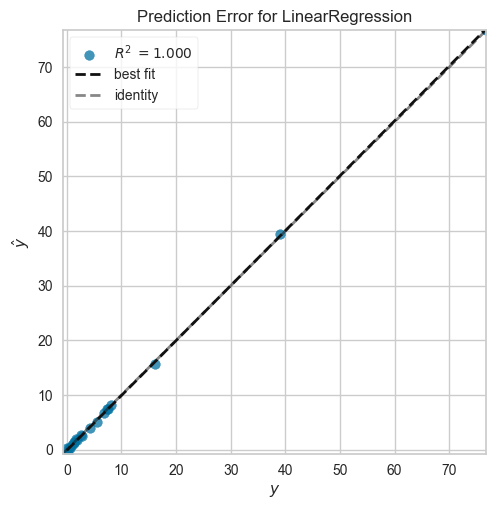

In [7]:
s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

In [8]:
s_sim = RegressionExperiment()
s_sim.setup(data=data_sim_df, target="expected_value", train_size=0.8, session_id=42)
best_sim = s_sim.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(100, 10)"
4,Transformed data shape,"(100, 10)"
5,Transformed train set shape,"(80, 10)"
6,Transformed test set shape,"(20, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,4.6404,104.4798,8.0794,-0.0083,0.7790,1.7047,0.0040
par,Passive Aggressive Regressor,6.4377,153.3063,9.9502,-0.6974,1.0826,4.0028,0.0030
br,Bayesian Ridge,6.0132,115.5998,9.0682,-0.8649,0.9382,5.6716,0.0040
lightgbm,Light Gradient Boosting Machine,7.3493,147.9386,10.0422,-1.2865,1.1204,4.5016,0.0190
lr,Linear Regression,8.2551,553.2090,14.4612,-1.6612,1.0448,8.5013,0.0040
ridge,Ridge Regression,6.6561,118.9893,9.1906,-1.6731,1.0401,3.7821,0.0030
knn,K Neighbors Regressor,6.6785,132.3557,9.8032,-1.9814,1.1252,4.6626,0.0070
lasso,Lasso Regression,6.8486,147.9407,10.1085,-2.3298,1.1243,5.7019,0.0030
llar,Lasso Least Angle Regression,6.8486,147.9407,10.1085,-2.3298,1.1243,5.7019,0.0040
omp,Orthogonal Matching Pursuit,7.4082,127.7241,9.7665,-2.4571,1.1139,6.2138,0.0030


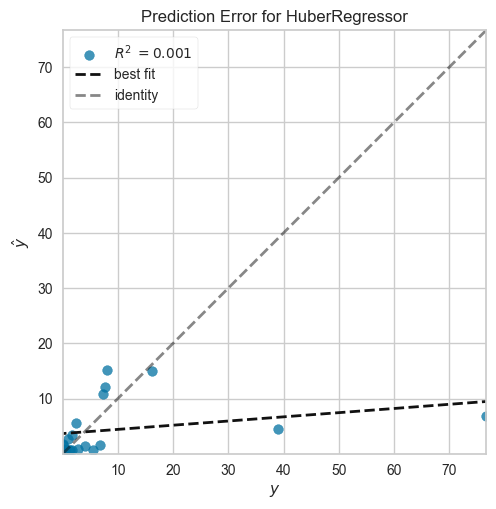

In [9]:
s_sim.plot_model(best_sim, plot="error")

## Trotter (Simulation, Noisy)

In [10]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df, target="expected_value", train_size=0.8, session_id=42
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(100, 10)"
4,Transformed data shape,"(100, 10)"
5,Transformed train set shape,"(80, 10)"
6,Transformed test set shape,"(20, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,4.7021,108.9830,8.2514,-0.0235,0.7773,1.5310,0.0050
br,Bayesian Ridge,6.0130,115.5949,9.0678,-0.8645,0.9381,5.6716,0.0040
lightgbm,Light Gradient Boosting Machine,7.3359,148.0227,10.1109,-1.4465,1.1244,6.1005,0.0200
par,Passive Aggressive Regressor,6.3807,162.5506,10.4137,-1.7320,1.1046,3.9453,0.0030
ridge,Ridge Regression,6.7028,120.3862,9.2499,-1.7340,1.0493,3.9567,0.0030
knn,K Neighbors Regressor,6.6785,132.3557,9.8032,-1.9814,1.1252,4.6626,0.0050
omp,Orthogonal Matching Pursuit,7.4128,128.1312,9.7794,-2.4673,1.1154,6.2298,0.0030
lasso,Lasso Regression,6.9938,150.3871,10.2466,-2.4835,1.1557,6.5408,0.0030
llar,Lasso Least Angle Regression,6.9938,150.3871,10.2466,-2.4835,1.1557,6.5408,0.0060
rf,Random Forest Regressor,7.2341,156.9697,10.7128,-2.5010,1.1626,5.3928,0.0190


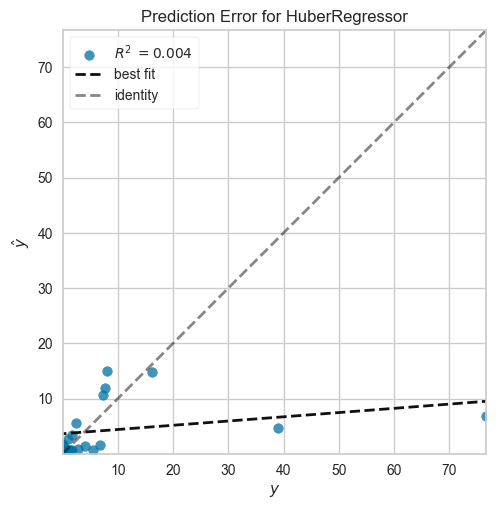

In [11]:
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

In [12]:
s_nmit = RegressionExperiment()
s_nmit.setup(data=data_nmit_df, target="expected_value", train_size=0.8)
best_nmit = s_nmit.compare_models(turbo=True)

,Description,Value
0,Session id,8250
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(100, 10)"
4,Transformed data shape,"(100, 10)"
5,Transformed train set shape,"(80, 10)"
6,Transformed test set shape,"(20, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,5.0254,143.7188,8.3589,0.1728,0.6741,3.6371,0.0030
et,Extra Trees Regressor,3.4151,52.2105,6.0995,0.0338,0.4875,1.0352,0.0140
knn,K Neighbors Regressor,3.3793,70.4877,6.9210,-0.0245,0.4645,1.0734,0.0050
huber,Huber Regressor,4.3475,91.2623,6.8424,-0.1842,0.6489,3.8622,0.0080
rf,Random Forest Regressor,3.7638,65.7430,6.8434,-0.1938,0.4969,1.0985,0.0180
ada,AdaBoost Regressor,4.0016,74.2689,6.6159,-0.3401,0.6171,2.4149,0.0070
gbr,Gradient Boosting Regressor,3.8979,69.5099,6.9853,-0.3980,0.5045,1.0190,0.0090
dt,Decision Tree Regressor,4.3933,108.4866,8.0967,-0.6251,0.5867,1.0593,0.0030
ridge,Ridge Regression,6.2150,117.6367,8.7291,-2.6784,0.9081,8.2063,0.0030
br,Bayesian Ridge,5.4465,62.3217,7.1669,-2.9149,0.9182,7.9102,0.0040


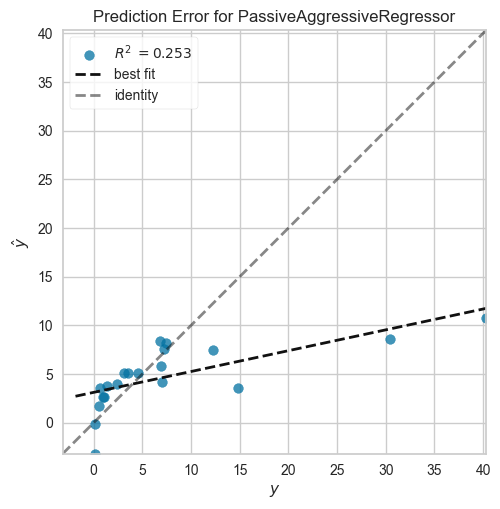

In [13]:
s_nmit.plot_model(best_nmit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.6710,91.9350,9.5883,-3.0545,0.6079,0.9616
1,6.9752,239.7560,15.4841,0.6497,0.5251,1.5227
2,5.7569,176.8411,13.2982,0.7384,0.2620,0.4175
3,4.6820,90.1733,9.4960,-0.5311,0.5679,1.2040
4,2.1014,17.3081,4.1603,0.0296,0.6025,0.7110
5,0.8905,1.0378,1.0187,-0.1291,0.3378,0.7603
6,2.8979,51.6486,7.1867,0.8025,0.3575,1.9449
7,0.9323,1.8162,1.3477,0.4645,0.3482,0.6134
8,1.6224,4.8160,2.1945,0.7711,0.3995,1.8277


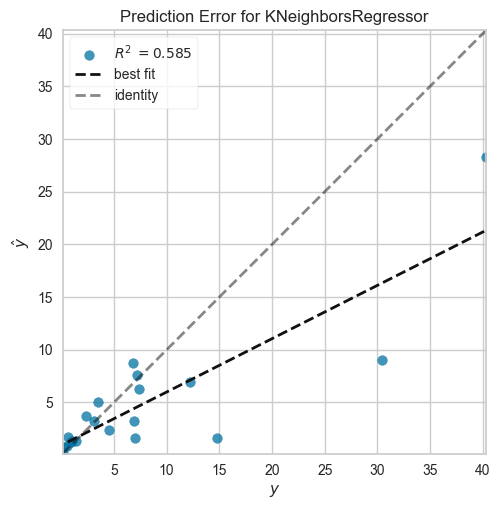

In [20]:
manual_model_nmit = s_nmit.create_model("knn")
s_nmit.plot_model(manual_model_nmit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.0043,22.0364,4.6943,0.0282,0.8407,6.5930
1,9.9997,236.6371,15.3830,0.6543,1.1295,15.1884
2,11.9997,405.7234,20.1426,0.3999,1.0035,5.1587
3,5.4673,35.4617,5.9550,0.3979,1.1224,5.4382
4,7.2366,73.0851,8.5490,-3.0978,1.5458,9.9201
5,5.0449,33.8689,5.8197,-35.8486,1.0162,5.6594
6,9.7326,113.9205,10.6734,0.5644,1.5554,27.6377
7,7.2793,63.1288,7.9454,-17.6132,1.4864,14.0749
8,4.9767,38.5305,6.2073,-0.8316,1.2340,38.0983


Fitting 10 folds for each of 10 candidates, totalling 100 fits


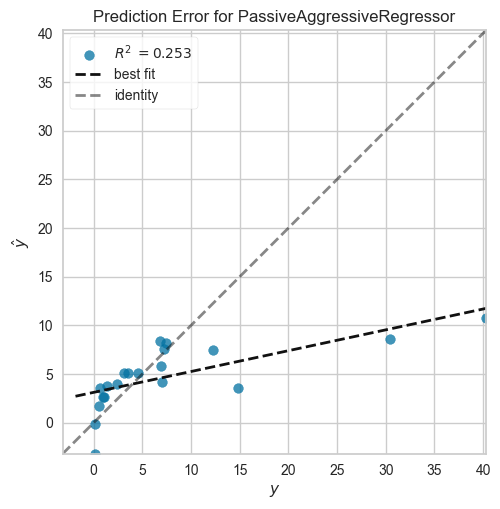

In [23]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [14]:
s_mit = RegressionExperiment()
s_mit.setup(data=data_mit_df, target="expected_value", train_size=0.8, session_id=42)
best_mit = s_mit.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(100, 10)"
4,Transformed data shape,"(100, 10)"
5,Transformed train set shape,"(80, 10)"
6,Transformed test set shape,"(20, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,3.1452,52.5440,5.7571,-0.1966,0.5190,1.1265,0.0060
huber,Huber Regressor,4.1278,71.3447,6.8170,-0.6179,0.6626,4.1455,0.0050
ada,AdaBoost Regressor,4.5606,62.7039,6.7649,-1.9844,0.7752,3.4638,0.0070
lasso,Lasso Regression,6.1507,129.0347,9.2530,-2.1802,0.9741,3.9482,0.0030
llar,Lasso Least Angle Regression,6.1507,129.0347,9.2530,-2.1802,0.9741,3.9482,0.0030
et,Extra Trees Regressor,3.6920,64.2224,6.6002,-2.3067,0.5600,1.2427,0.0150
gbr,Gradient Boosting Regressor,3.9327,72.6465,7.0504,-2.4513,0.5829,1.4871,0.0080
en,Elastic Net,7.2042,152.6624,10.4657,-2.9827,1.2033,8.1028,0.0070
ridge,Ridge Regression,5.4847,88.3659,7.9971,-2.9879,0.8581,5.7185,0.0030
dummy,Dummy Regressor,7.4427,159.4475,10.7687,-3.2805,1.2462,8.8863,0.0030


In [15]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.8332,85.0298,9.2212,0.7276,0.5238,1.2534


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value,prediction_label
83,0.822266,0.638625,-0.236867,0.638074,-0.257756,0.631297,-0.272781,0.623145,-0.268894,1.005102,1.282018
53,0.872559,0.703263,-0.124316,0.725151,-0.052667,0.699277,0.088520,0.674657,0.152174,76.638138,43.965462
70,0.813477,0.626974,-0.236646,0.630243,-0.263943,0.619834,-0.273552,0.604235,-0.298391,0.389050,1.108550
45,0.866943,0.708189,-0.207950,0.704482,-0.167469,0.691337,-0.162541,0.684160,-0.156357,5.474206,3.430436
44,0.873779,0.734839,-0.186441,0.722327,-0.124833,0.737399,-0.050232,0.725106,0.008306,7.629771,20.110683
39,0.866699,0.689432,-0.211345,0.692665,-0.239198,0.684265,-0.214055,0.677095,-0.205345,2.774590,2.857684
22,0.885986,0.731644,-0.169151,0.729457,-0.121826,0.739942,-0.072318,0.725651,-0.047811,6.844440,13.304309
80,0.818604,0.653323,-0.224523,0.653514,-0.255460,0.657365,-0.227735,0.648011,-0.234532,1.237418,5.094842
10,0.873047,0.704705,-0.163082,0.704638,-0.118569,0.719392,-0.083428,0.724302,-0.042017,7.379588,11.855947
0,0.882080,0.715251,-0.221463,0.701448,-0.226729,0.690626,-0.241668,0.666869,-0.242880,4.172305,1.015658


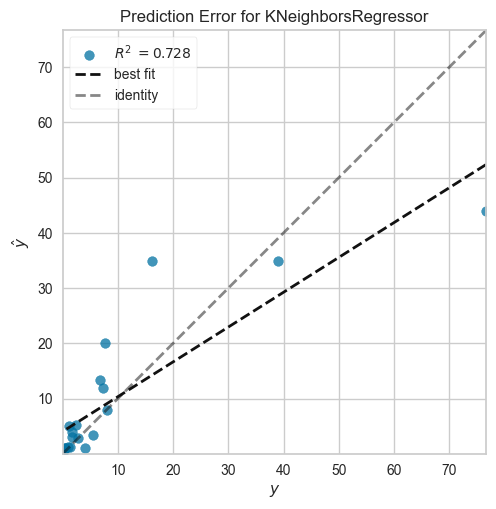

In [16]:
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5235,40.4463,6.3597,0.3585,0.6412,2.2236
1,2.5221,14.0775,3.7520,-2.5283,0.6520,1.3564
2,3.4593,39.6687,6.2983,-23.9128,0.7043,1.1998
3,5.6301,61.1401,7.8192,0.2900,0.7811,1.4809
4,7.1538,294.6099,17.1642,0.5728,0.5187,0.8896
5,0.5853,0.6768,0.8227,0.8584,0.2152,0.5747
6,3.0072,23.9683,4.8957,0.8721,0.5435,0.4490
7,3.7142,33.3398,5.7741,0.7424,0.4013,0.4495
8,0.8367,1.7249,1.3133,0.5562,0.2836,0.4864


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


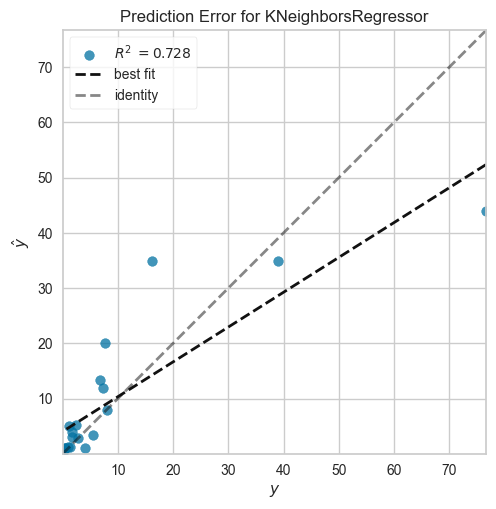

In [17]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7810,71.0011,8.4262,-0.1261,0.6664,2.4365
1,1.5021,5.4158,2.3272,-0.3574,0.4776,1.0519
2,1.7923,10.5021,3.2407,-5.5955,0.4833,0.7609
3,4.0807,58.7241,7.6632,0.3180,0.6403,0.9393
4,7.5170,283.3763,16.8338,0.5891,0.5988,1.0338
5,1.3539,3.6992,1.9233,0.2258,0.5401,1.5449
6,4.9497,56.8890,7.5425,0.6964,0.5933,0.5077
7,2.5840,15.0291,3.8767,0.8839,0.2985,0.3401
8,0.8658,1.9447,1.3945,0.4997,0.3100,1.2969


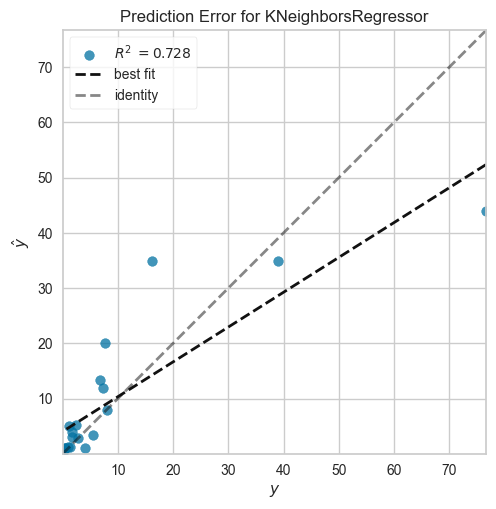

In [18]:
manual_model_mit = s_mit.create_model("knn")
s_mit.plot_model(manual_model_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8435,4.2801,2.0689,0.9321,0.5486,3.1528
1,1.4686,5.0725,2.2522,-0.2713,0.4734,1.5313
2,2.1632,9.6266,3.1027,-5.0457,0.5567,1.2933
3,4.1834,56.9339,7.5455,0.3388,0.6184,1.0633
4,9.5041,551.9908,23.4945,0.1996,0.7317,1.2705
5,1.4476,2.1589,1.4693,0.5482,0.6136,2.6862
6,8.2351,134.3492,11.5909,0.2829,0.7819,1.0902
7,4.5882,68.2870,8.2636,0.4724,0.4539,0.4268
8,1.2778,2.4822,1.5755,0.3614,0.4768,2.6266


Fitting 10 folds for each of 10 candidates, totalling 100 fits


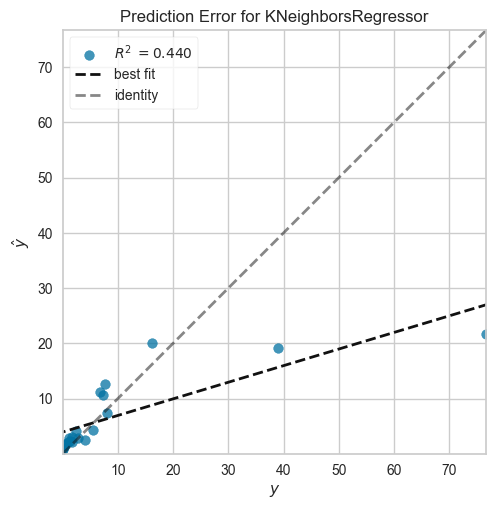

In [19]:
tuned_manual_model_mit = s_mit.tune_model(manual_model_mit, optimize="R2")
s_mit.plot_model(tuned_manual_model_mit, plot="error")